In [1]:
%pylab
%matplotlib inline
rc('text', usetex = True)
import pandas as pd
from numpy.linalg import solve

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
## flags for the various geometric constraints, T/F
usemilkyway = True
useNGC4258 = True
uselmc = True
kappa = 0

In [3]:
## Grab data
filename = '../data/r16_table4.out'

## set up dataframes
sne_start = 40
sne_end = 59
sne_lines = arange(sne_start,sne_end)
sne = pd.DataFrame(columns = ['Host', 'sne', 'm_B', 'err'], index = arange(sne_end - sne_start))
ceph_start = 70
ceph_end = 2346
cepheid_lines = arange(ceph_start,ceph_end)
cepheids = pd.DataFrame(columns = ['Field','RA','DEC','ID','Period','VminusI','m_H','sigma_tot','Z'], 
                        index = arange(ceph_end - ceph_start),
                       dtype = 'float')

## fill dataframes
f = file(filename)
for i, line in enumerate(f):
    if i in sne_lines:
        sne.loc[i-sne_start] = line.lower().split()
    if i in cepheid_lines:
        cepheids.loc[i-ceph_start] = line.lower().split()

f.close()

## Switch to float from string where needed, and cut unwanted cepheids from sample
cepheids = cepheids.apply(lambda x: pd.to_numeric(x, errors='ignore') );
if usemilkyway == False:
    cepheids = cepheids[cepheids.Field != 'galaxy']
    cepheids.reset_index(drop = True, inplace = True)
if (uselmc == False) & (usemilkyway == False):
    print 'cutting out lmc cepheids'
    cepheids = cepheids[cepheids.Field != 'lmc']
    cepheids.reset_index(drop = True, inplace = True)
sne = sne.apply(lambda x: pd.to_numeric(x, errors='ignore') );

## Add milky way parallax information to cepheids
parallaxes = {'bgcru': (2.23, 0.30,-0.15), 
              'dtcyg':(2.19,0.33, -0.18), 
              'ffaql':(2.64,0.16, -0.03),
              'rtaur':(2.31, 0.19,-0.06),
              'sscma':(0.348, 0.038, -0.04),
              'sucas':(2.57,  0.33, -0.13 ),
              'syaur':(0.428, 0.054, -0.04),
              'tvul':(2.06,0.22,-0.09 ),
              'wsgr':(2.30, 0.19, -0.06),
              'xsgr':(3.17, 0.14, -0.02),
              'ysgr':(2.13, 0.29, -0.15),
              'betador':(3.26, 0.14, -0.02),
              'delceph':(3.71,0.12,-0.01),
              'etagem':(2.74,0.12,-0.02),
              'lcar':(2.03,0.16,-0.05)
             }
parallaxes = pd.DataFrame.from_dict(parallaxes, orient = 'index', )
parallaxes.reset_index(inplace=True)
parallaxes.columns = ['ID', 'parallax', 'p_err', 'LK']
cepheids = cepheids.merge(parallaxes, on = 'ID', how = 'left').fillna({'parallax':inf, 'p_err':0, 'LK':0})
numcephs = (cepheids.m_H).size
numsne = (sne.m_B).size

In [4]:
cepheids.loc[cepheids.Field == 'lmc', 'sigma_tot']

1501    0.081
1502    0.082
1503    0.084
1504    0.081
1505    0.086
1506    0.085
1507    0.084
1508    0.086
1509    0.084
1510    0.085
1511    0.081
1512    0.085
1513    0.082
1514    0.082
1515    0.090
1516    0.104
1517    0.085
1518    0.084
1519    0.101
1520    0.095
1521    0.085
1522    0.085
1523    0.091
1524    0.087
1525    0.085
1526    0.084
1527    0.083
1528    0.087
1529    0.086
1530    0.084
        ...  
2246    0.100
2247    0.106
2248    0.087
2249    0.094
2250    0.111
2251    0.117
2252    0.108
2253    0.098
2254    0.092
2255    0.091
2256    0.090
2257    0.108
2258    0.116
2259    0.100
2260    0.115
2261    0.095
2262    0.111
2263    0.114
2264    0.095
2265    0.091
2266    0.100
2267    0.097
2268    0.105
2269    0.095
2270    0.095
2271    0.101
2272    0.091
2273    0.101
2274    0.099
2275    0.101
Name: sigma_tot, dtype: float64

In [5]:
#### Data (magnitude) vector [ceph_1, ...., ceph_ncephs, sn_1, ... , sn_nsne, 0, 0, 0] (last 3 constraint eqns)

### Cepheids
data = (cepheids.m_H - 0.39 * cepheids.VminusI)
#### Subtract out the geometric distances we have, which is easy to do with a Dataframe but hard with an array.
data = pd.DataFrame({'data':data, 'Field':array(cepheids.Field), 'ID': array(cepheids.ID)})
data.loc[data.Field == 'n4258','data'] += -29.387 
data.loc[data.Field == 'lmc', 'data'] +=  -18.494
data.loc[cepheids.parallax != inf, 'data']-= (5 * log10((1/cepheids.loc[cepheids.parallax != inf, 'parallax'])*1e-3)
                                              +25
                                              - cepheids.loc[cepheids.parallax != inf, 'LK']
                                              )
data = data['data'].tolist() 

### SNe
data += sne.m_B.tolist()

### Constraint zeros
numconstraints = 3
if uselmc == False: numconstraints -= 1
if useNGC4258 == False: numconstraints -= 1
for i in arange(numconstraints):
    data += [0]
data = array(data)

In [6]:
#### Error matrix:
## cepheids
variance = cepheids.sigma_tot**2 ### intrinsic, color, phase, and, crowding error
variance += (cepheids.p_err / cepheids.parallax * 5/log(10))**2 ### Add error to galaxy cepheids associated with parallax
variance = variance.tolist()

### SNe
variance += (sne.err**2).tolist()


### Constraint equations
variance += [0.03**2] ### HST/ground zero point error
if uselmc:
    variance += [0.0452**2] ###dmulmc
if useNGC4258:
    variance += [(0.02616*2.17)**2] ###dmungc4258

    
## make it a (diagonal) matrix
cinv = diag(1/array(variance))

In [7]:
#### Parameters
paramnames = []
for field in (set(cepheids.Field)):
    if (field != 'galaxy') & (field != 'lmc') & (field != 'n4258'):
        paramnames += ['mu_'+field]
paramnames += ['dmu_n4258']
paramnames += ['M_ceph']
if usemilkyway or uselmc:
    paramnames += ['dmu_lmc']
paramnames += ['b']
paramnames += ['M_sne']
paramnames += ['Z_w']
paramnames += ['delta_zp']
paramnames += ['b_l']

In [8]:
### Design matrix



### Let's do the cepheid columns first
L = zeros([numcephs, len(paramnames)])
L = pd.DataFrame(L, columns = paramnames)
## magnitudes depend on absolute magnitudes
L.loc[:,'M_ceph'] = 1

## and distance moduli
fields = set(cepheids.Field)
fields.remove('n4258')
if usemilkyway: fields.remove('galaxy')
if (usemilkyway) or (uselmc): 
    fields.remove('lmc')
    L.loc[cepheids.Field == 'lmc', 'dmu_lmc'] = 1      ## Treating these differently because that's what's done in R16

for field in fields: ## loop over every field but the MW, LMC, and NGC 4258
    L.loc[cepheids.Field == field, 'mu_'+field] = 1
L.loc[cepheids.Field == 'n4258', 'dmu_n4258'] = 1  ## Treating these differently because that's what's done in R16
L.loc[cepheids.Field == 'galaxy', 'delta_zp'] = 1  ## add zero point error to LMC and Galaxy
L.loc[cepheids.Field == 'lmc', 'delta_zp'] =1
L.loc[cepheids.Period >= 10, 'b'] = (log10(cepheids.loc[cepheids.Period>=10, 'Period'])-1.0)  ## break in P-L relation at P=10
L.loc[cepheids.Period < 10, 'b_l'] = (log10(cepheids.loc[cepheids.Period<10, 'Period'])-1.0)
L.loc[:, 'Z_w']  = cepheids.Z - 8.9#mean(cepheids.Z)#8.9 ## Metallicity
Ltot = L


### Now the SNe:
L = pd.DataFrame(zeros([numsne, len(paramnames)]), columns = paramnames)
L.loc[:, 'M_sne'] = 1
for host in (set(sne.Host)):
    L.loc[sne.Host == host, 'mu_'+host] = 1
Ltot = Ltot.append(L)

### Now the constraint equations
L = pd.DataFrame(zeros([numconstraints, len(paramnames)]), columns = paramnames)


L.loc[0,'delta_zp'] = 1
count = 1
if uselmc:
    L.loc[count,'dmu_lmc'] = 1
    count += 1
    print 'using LMC constraint'
if useNGC4258:
    L.loc[count,'dmu_n4258'] = 1
    count += 1
    print 'using NGC 4258 constraint'
Ltot = Ltot.append(L)

### Reset the index so it goes from 0, ..., num_cephs + num_sne + numconstraints - 1
Ltot.reset_index(inplace = True, drop = True)
Ltot.shape
cinv.shape

using LMC constraint
using NGC 4258 constraint


(2298, 2298)

In [9]:
param_cinv = (dot(Ltot.T, dot(cinv, Ltot))) ## The A of Aq = B
param_cinv = pd.DataFrame(param_cinv, columns = paramnames, index = paramnames)


In [10]:
LtCinv = dot(Ltot.T, cinv) ## The B of Aq = B
LtCinv = pd.DataFrame(LtCinv, index = paramnames)

In [11]:
## best fit and error
bestfit = dot(inv(param_cinv), dot(LtCinv, data))
#bestfit = solve(param_cinv, dot(LtCinv, data)) ## q = A^-1 B
error = sqrt(diag(inv(param_cinv))) ## error covariance is A^{-1}, so I do need to invert this.


In [12]:
### Append the remaining information we need to q_best
q = pd.DataFrame({'best_fit':bestfit, 'error':error}, index = paramnames)
fit = q.copy()
fit = fit.append(pd.DataFrame({'best_fit':0.71273*1.005, 'error':0.00176}, index = ['a_B']))
H_0val = 10**(0.2 * fit.loc['M_sne','best_fit'] +  fit.loc['a_B', 'best_fit'] + 5)
H_0err = H_0val * sqrt(
                                (fit.loc['a_B', 'error'] * log(10))**2 
                                + (log(10)/5 *fit.loc['M_sne', 'error'] )**2
    )
fit = fit.append(pd.DataFrame({'best_fit': H_0val, 'error': H_0err}, index = ['H_0']))

In [13]:
fit.T['H_0']

best_fit    73.106693
error        1.691593
Name: H_0, dtype: float64

In [14]:
fields = uselmc * ['_lmc'] + useNGC4258 *['_NGC4258'] + usemilkyway * ['_MW']
fields = ''.join(fields)
pd.DataFrame(data).to_csv('y'+fields+'.csv')
Ltot.to_csv('L'+fields+'.csv')
cinv = pd.DataFrame(diag(cinv))
cinv.to_csv('cinv'+fields+'.csv')
fit.to_csv('q'+fields+'.csv')

In [15]:
### Row and colum indexing
#Ltot.info() ## information about the dataframe
#Ltot[0:10] ## row slicing
#Ltot[['M_ceph', 'b']] ## column slicing
#q.loc[fit.index == 'b','best_fit'] ## slice on both with .loc, and use booleans

In [16]:
start = {}
for field in set(cepheids.Field):
    if( field != 'galaxy') & (field != 'lmc') & (field != 'n4258'):
        start[field] = fit.best_fit['mu_'+field]
start

{'m101': 29.142177890200344,
 'm31': 24.431038948926698,
 'n1015': 32.561438633694081,
 'n1309': 32.524311299375483,
 'n1365': 31.299317096514301,
 'n1448': 31.329827537695792,
 'n2442': 31.523195405447723,
 'n3021': 32.410980141778964,
 'n3370': 32.088982330191186,
 'n3447': 31.920563180060981,
 'n3972': 31.635135732312051,
 'n3982': 31.689114021979151,
 'n4038': 31.394512791640807,
 'n4424': 30.840832502017918,
 'n4536': 30.912971700219828,
 'n4639': 31.576500589675561,
 'n5584': 31.797251210181685,
 'n5917': 32.271211885388936,
 'n7250': 31.520886634704254,
 'u9391': 32.89323094209692}

In [17]:
fit.to_csv('matrix_method.csv')

In [18]:
fit.loc['mu_m101', 'best_fit']

29.142177890200344

-5.87927023276 0.0902620751229
-5.91653937958 0.111272829448


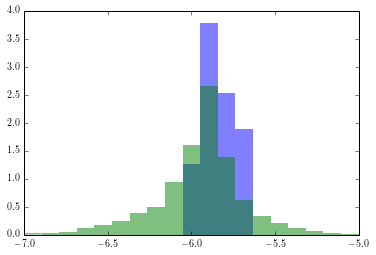

In [19]:
cepheids['M'] = pd.Series(zeros(cepheids.m_H.size))
cepheids['M_err'] = pd.Series(zeros(cepheids.m_H.size))

for field in set(cepheids.Field):
    if (field != 'galaxy') and (field != 'lmc') and (field != 'n4258'):
        x = list(cepheids.loc[cepheids.Field ==field, 'm_H'] - fit.loc['mu_'+field, 'best_fit']
              - 0.39 * cepheids.loc[cepheids.Field == field, 'VminusI']
                - (cepheids.loc[cepheids.Field == field, 'Period'] >= 10)* fit.loc['b', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
                 - (cepheids.loc[cepheids.Field == field, 'Period'] < 10) * fit.loc['b_l', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
                 )
        cepheids.loc[cepheids.Field == field, 'M'] = x
        if max(x) > 0:

            print x, field

        x = list(sqrt(cepheids.loc[cepheids.Field ==field, 'sigma_tot']**2
                     # + fit.loc['mu_'+field, 'error']**2
                     + (fit.loc['b', 'error'] * (-1.0 + log10(cepheids.loc[cepheids.Field == field, 'Period']))**2)))
        cepheids.loc[cepheids.Field == field, 'M_err'] = x
    if field == 'lmc':
        x = list(cepheids.loc[cepheids.Field == field, 'm_H'] - fit.loc['dmu_'+field, 'best_fit'] - 18.494
         - 0.39 * cepheids.loc[cepheids.Field == field, 'VminusI']
                 - (cepheids.loc[cepheids.Field == field, 'Period'] >= 10)* fit.loc['b', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
                 - (cepheids.loc[cepheids.Field == field, 'Period'] < 10) * fit.loc['b_l', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
                 )
    
        cepheids.loc[cepheids.Field == field, 'M'] = x
        x = list(sqrt(cepheids.loc[cepheids.Field ==field, 'sigma_tot']**2
                      #+ fit.loc['dmu_'+field, 'error']**2
                     + (fit.loc['b', 'error'] * (-1.0 + log10(cepheids.loc[cepheids.Field == field, 'Period']))**2)))
        cepheids.loc[cepheids.Field == field, 'M_err'] = x
        
        
    if field == 'n4258':
        x = list(cepheids.loc[cepheids.Field == field, 'm_H'] - fit.loc['dmu_'+field, 'best_fit'] - 29.387
         - 0.39 * cepheids.loc[cepheids.Field == field, 'VminusI']
                 - (cepheids.loc[cepheids.Field == field, 'Period'] >= 10)* fit.loc['b', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
                 - (cepheids.loc[cepheids.Field == field, 'Period'] < 10) * fit.loc['b_l', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
                 )
        cepheids.loc[cepheids.Field == field, 'M'] = x
        x = list(sqrt(cepheids.loc[cepheids.Field ==field, 'sigma_tot']**2
                      #+ fit.loc['dmu_'+field, 'error']**2
                     + (fit.loc['b', 'error'] * (-1.0 + log10(cepheids.loc[cepheids.Field == field, 'Period']))**2)))
        cepheids.loc[cepheids.Field == field, 'M_err'] = x
        
    if field == 'galaxy':
        x = list(
            cepheids.loc[cepheids.Field == field, 'm_H']
            -0.39 * cepheids.loc[cepheids.Field == field, 'VminusI']
            - (cepheids.loc[cepheids.Field == field, 'Period'] >= 10)* fit.loc['b', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
            - (cepheids.loc[cepheids.Field == field, 'Period'] < 10) * fit.loc['b_l', 'best_fit'] *  (-1 + log10(cepheids.loc[cepheids.Field == field, 'Period']))
            - (5 * log10((1/cepheids.loc[cepheids.Field == field, 'parallax'])*1e-3)
                                              +25
                                              - cepheids.loc[cepheids.Field == field, 'LK']
                                                                                                                              
                )
              )
        cepheids.loc[cepheids.Field == field, 'M'] = x
hist(cepheids.loc[cepheids.Field == 'galaxy', 'M'], bins = linspace(-7, -5, 20), normed = True, lw = 0, label = 'galactic', alpha = 0.5)        
hist(cepheids.loc[cepheids.Field != 'galaxy', 'M'], bins = linspace(-7, -5, 20), normed = True, lw = 0, label = 'extra-galactic', alpha = 0.5)
from scipy.stats import cauchy, t, norm, chisquare
(mu, sigma) = cauchy.fit(cepheids.loc[cepheids.Field == 'galaxy', 'M'])
x = linspace(-7, -5, 5000)
#plot(x, cauchy.pdf(x, loc =mu, scale = sigma), color = 'b', lw = 4)
print mu, sigma
(mu, sigma) = cauchy.fit(cepheids.loc[cepheids.Field != 'galaxy', 'M'])
#plot(x, cauchy.pdf(x, loc =mu, scale = sigma), color = 'g', lw = 4)
#plot(x, norm.pdf(x, loc = fit.loc['M_ceph', 'best_fit'], scale = fit.loc['M_ceph', 'error'])*3/5, lw =4 )
xlim(-7, -5)

print mu, sigma
#plot(linspace (-7.5, -4.5, 500),cauchy.pdf(linspace (-7.5, -4.5, 500),  loc = mu, scale = sigma), lw = 4)
#figure()
#hist(cepheids.loc[cepheids.M != 0, 'M_err'], bins = 300)
        
newcephs = cepheids[cepheids.Field != 'galaxy']
#newcephs['M'] = M
#newcephs['M_err'] = M_err
        
    


In [20]:
for field in set(cepheids.Field):
    print field, (mean(cepheids.loc[cepheids.Field == field, 'M']) - mean(cepheids['M']))
    if field in set(sne.Host):
        print sne.loc[sne.Host == field, 'm_B'] - fit.loc['mu_'+field, 'best_fit'] - fit.loc['M_sne', 'best_fit']

m101 -0.0772353283783
18   -0.133995
Name: m_B, dtype: float64
n3370 -0.0179908219581
1    0.0847
Name: m_B, dtype: float64
n3447 0.0404972028614
11    0.042119
Name: m_B, dtype: float64
n1448 -0.0498712591926
10    0.132855
Name: m_B, dtype: float64
u9391 0.0180938178119
15   -0.161548
Name: m_B, dtype: float64
n3982 0.0241816159599
3   -0.196431
Name: m_B, dtype: float64
galaxy 0.103848481516
n1365 0.0408111677
9   -0.119635
Name: m_B, dtype: float64
lmc 0.0480071600877
m31 -0.000760299004217
n3021 0.0505898106621
0   -0.186298
Name: m_B, dtype: float64
n1309 -0.0480401140042
2   -0.070629
Name: m_B, dtype: float64
n4424 -0.0329414602622
14   -0.03315
Name: m_B, dtype: float64
n4038 -0.057696772142
6    0.10017
Name: m_B, dtype: float64
n5917 -0.0164645032119
13   -0.001529
Name: m_B, dtype: float64
n5584 -0.0156983187958
5    0.165431
Name: m_B, dtype: float64
n2442 -0.0354842622564
17    0.014487
Name: m_B, dtype: float64
n7250 -0.107111531144
12    0.043796
Name: m_B, dtype: float

In [21]:
## same field
for field in set(cepheids.Field):
    print field, mean(cepheids.loc[cepheids.Field == field,'M'])- mean(cepheids.M), cepheids.loc[cepheids.Field == field,'M'].size

m101 -0.0772353283783 251
n3370 -0.0179908219581 63
n3447 0.0404972028614 80
n1448 -0.0498712591926 54
u9391 0.0180938178119 28
n3982 0.0241816159599 16
galaxy 0.103848481516 15
n1365 0.0408111677 32
lmc 0.0480071600877 775
m31 -0.000760299004217 372
n3021 0.0505898106621 18
n1309 -0.0480401140042 44
n4424 -0.0329414602622 3
n4038 -0.057696772142 13
n5917 -0.0164645032119 13
n5584 -0.0156983187958 83
n2442 -0.0354842622564 141
n7250 -0.107111531144 22
n4258 -0.0272047066513 139
n1015 -0.0666723169914 14
n4536 0.0205279964725 33
n3972 -0.0424193951027 42
n4639 -0.158374093065 25


In [22]:
## same field
kappa = 0
same_field = []
newcephs = cepheids[cepheids.Field != 'galaxy'].reset_index()
for f1 in set(newcephs.Field):#.remove('galaxy'):
    print 'doing field', f1, '(%6.0f cepheids)'%(newcephs[newcephs.Field == f1].shape[0])
    f2 = f1
    vals = []
    for i in arange(newcephs[newcephs.Field == f1].shape[0]):
        for j in arange(i+1,newcephs[newcephs.Field == f2].shape[0]):
            cephsf1 = newcephs[newcephs.Field == f1].reset_index()
            cephsf2 = newcephs[newcephs.Field == f2].reset_index()
            #print cephsf1[cephsf1.index == 0]
            num = (array(cephsf1.loc[cephsf1.index == i,'M']) - array(cephsf2.loc[cephsf2.index == j, 'M']))
            den =sqrt(array(cephsf1.loc[cephsf1.index == i,'M_err'])**2 
                      + array(cephsf2.loc[cephsf2.index ==j,'M_err'])**2
                      - kappa * array(cephsf2.loc[cephsf2.index ==j,'M_err']) *array(cephsf1.loc[cephsf1.index == i,'M_err'])
                     )
            #if (i % 100) == 0: print 'i = ', i
            vals += list(num/den)
            #print vals
    same_field += vals


doing field m101 (   251 cepheids)
doing field n3370 (    63 cepheids)
doing field n3447 (    80 cepheids)
doing field n1448 (    54 cepheids)
doing field u9391 (    28 cepheids)
doing field n3982 (    16 cepheids)
doing field n1309 (    44 cepheids)
doing field n1365 (    32 cepheids)
doing field n7250 (    22 cepheids)
doing field m31 (   372 cepheids)
doing field n3021 (    18 cepheids)
doing field n4424 (     3 cepheids)
doing field n4038 (    13 cepheids)
doing field n5917 (    13 cepheids)
doing field n5584 (    83 cepheids)
doing field n2442 (   141 cepheids)
doing field lmc (   775 cepheids)
doing field n4258 (   139 cepheids)
doing field n1015 (    14 cepheids)
doing field n4536 (    33 cepheids)
doing field n3972 (    42 cepheids)
doing field n4639 (    25 cepheids)


In [23]:
### Different field
# diff_field = []
# fields = set(newcephs.Field)

# for f1 in set(newcephs.Field):
#     print 'crossing field', f1,'(%6.0f cepheids)'%newcephs[newcephs.Field == f1].shape[0]
#     fields.remove(f1)
#     fieldvals = []
#     for f2 in fields:
#         vals =[]
#         print '... with field', f2,'(%6.0f cepheids)'%newcephs[newcephs.Field == f2].shape[0]
#         for i in arange(newcephs[newcephs.Field == f1].shape[0]):
#             for j in arange(newcephs[newcephs.Field == f2].shape[0]):
#                 cephsf1 = newcephs[newcephs.Field == f1].reset_index()
#                 cephsf2 = newcephs[newcephs.Field == f2].reset_index()
#                 num = (array(cephsf1.loc[cephsf1.index == i,'M']) - array(cephsf2.loc[cephsf2.index == j, 'M']))
#                 den = sqrt(array(cephsf1.loc[cephsf1.index == i,'M_err'])**2 + array(cephsf2.loc[cephsf2.index ==j,'M_err'])**2)

#                 vals += list(num/den)
#         fieldvals +=vals
        
#     diff_field += fieldvals


In [24]:
fig = figure(figsize = (5,4))
from scipy.stats import norm
#diff_field = list(diff_field) + [-x for x in diff_field]
hist(diff_field + [-x for x in diff_field], bins = linspace(-5,5,100), normed = True, linewidth = 0, alpha = 0.5, label = 'Cross');
(mu, sigma) = norm.fit(diff_field + [-x for x in diff_field])
print 'cross', mu, sigma
xvals = linspace(-5,5, 100)
yvals = 1.0/sqrt(2 * pi * sigma**2) * exp(-(xvals-mu)**2/2/sigma**2)
plot(xvals, yvals, color = 'b', linewidth = 3)
#same_field = list(same_field) + [-x for x in same_field]

hist(same_field+ [-x for x in same_field], bins = linspace(-5,5,100), normed = True, linewidth = 0, color = 'g', alpha = 0.5, label = 'Auto');
(mu, sigma) = norm.fit(same_field+ [-x for x in same_field])
print 'auto',mu, sigma
#yvals = 1.0/sqrt(2 * pi)* exp(-xvals**2/2)
#plot(xvals, yvals, color = 'r', linewidth = 2)
yvals = 1.0/sqrt(2 * pi * sigma**2) * exp(-(xvals-mu)**2/2/sigma**2)
plot(xvals, yvals, color = 'g', linewidth = 3)
#sigma = 1
#yvals = 1.0/sqrt(2 * pi * sigma**2) * exp(-(xvals-mu)**2/2/sigma**2)
#plot(xvals, yvals, color = 'b', linewidth = 3)

xlabel(r'$x = (M^0_i - M^0_j)/\sqrt{\sigma_i^2 + \sigma_j^2}$', fontsize = 18)
ylabel(r'$\mathcal{P}(x)$', fontsize = 18)
legend()
xlim(-3,3)
fig.subplots_adjust(left = 0.2, bottom = 0.2, top = 0.95, right = 0.95)
#gca().set_xscale('log')
savefig('../../papers/local_hubble/FIGURES/correlation_hist.png')


NameError: name 'diff_field' is not defined

In [ ]:
print 'done'

In [ ]:
as

In [ ]:
cepheids.loc[cepheids.Field == field, 'Period'] > 10

In [ ]:
fit

In [ ]:
fit.loc['a_B','best_fit']/1.005

In [ ]:
cepheids

In [ ]:
fit

In [ ]:
from scipy.stats import norm
plot(linspace(-4, 4, 100), norm.pdf(linspace(-4, 4, 100), scale = 1))

In [ ]:
yvals, xvals = (array([  6.90723002e-05,   3.45361501e-05,   3.45361501e-05,
          1.72680750e-04,   2.76289201e-04,   3.10825351e-04,
          1.72680750e-04,   4.14433801e-04,   3.45361501e-04,
          1.07062065e-03,   1.10515680e-03,   1.34690985e-03,
          1.89948825e-03,   3.21186196e-03,   3.59175961e-03,
          4.66238026e-03,   5.87114552e-03,   6.90723002e-03,
          9.39383282e-03,   1.11551765e-02,   1.37453877e-02,
          1.85113764e-02,   2.03417924e-02,   2.58330403e-02,
          3.23603726e-02,   3.59866684e-02,   4.34119407e-02,
          5.37382495e-02,   6.46516730e-02,   7.66011809e-02,
          9.03120325e-02,   1.06371342e-01,   1.21463640e-01,
          1.45846162e-01,   1.61111140e-01,   1.88981813e-01,
          2.18579294e-01,   2.40958719e-01,   2.73906206e-01,
          3.10618134e-01,   3.43462013e-01,   3.71988873e-01,
          4.13674006e-01,   4.46379740e-01,   4.85163836e-01,
          5.20390710e-01,   5.38522188e-01,   5.70122766e-01,
          5.91293426e-01,   5.91915076e-01,   5.92847552e-01,
          6.00480042e-01,   5.84973310e-01,   5.77893399e-01,
          5.50229943e-01,   5.24362367e-01,   4.93279832e-01,
          4.58950899e-01,   4.20822989e-01,   3.90811074e-01,
          3.48884188e-01,   3.14762472e-01,   2.78085081e-01,
          2.43790683e-01,   2.12293715e-01,   1.84699331e-01,
          1.60454953e-01,   1.40527595e-01,   1.19046109e-01,
          9.80826663e-02,   8.59604776e-02,   7.41145781e-02,
          6.14052749e-02,   5.21150505e-02,   4.19614224e-02,
          3.51232646e-02,   3.05644928e-02,   2.68000525e-02,
          2.11361239e-02,   1.92020995e-02,   1.45742553e-02,
          1.17077549e-02,   9.87733893e-03,   8.25413987e-03,
          6.63094082e-03,   5.28403096e-03,   4.31701876e-03,
          3.48815116e-03,   2.76289201e-03,   2.14124131e-03,
          1.86495210e-03,   1.31237370e-03,   1.03608450e-03,
          7.25259152e-04,   6.90723002e-04,   3.10825351e-04,
          3.79897651e-04,   2.76289201e-04,   1.03608450e-04,
          2.07216901e-04]),
 array([-3.42145998, -3.35473947, -3.28801896, -3.22129845, -3.15457794,
        -3.08785743, -3.02113692, -2.95441641, -2.8876959 , -2.82097539,
        -2.75425487, -2.68753436, -2.62081385, -2.55409334, -2.48737283,
        -2.42065232, -2.35393181, -2.2872113 , -2.22049079, -2.15377028,
        -2.08704977, -2.02032925, -1.95360874, -1.88688823, -1.82016772,
        -1.75344721, -1.6867267 , -1.62000619, -1.55328568, -1.48656517,
        -1.41984466, -1.35312414, -1.28640363, -1.21968312, -1.15296261,
        -1.0862421 , -1.01952159, -0.95280108, -0.88608057, -0.81936006,
        -0.75263955, -0.68591903, -0.61919852, -0.55247801, -0.4857575 ,
        -0.41903699, -0.35231648, -0.28559597, -0.21887546, -0.15215495,
        -0.08543444, -0.01871392,  0.04800659,  0.1147271 ,  0.18144761,
         0.24816812,  0.31488863,  0.38160914,  0.44832965,  0.51505016,
         0.58177067,  0.64849118,  0.7152117 ,  0.78193221,  0.84865272,
         0.91537323,  0.98209374,  1.04881425,  1.11553476,  1.18225527,
         1.24897578,  1.31569629,  1.38241681,  1.44913732,  1.51585783,
         1.58257834,  1.64929885,  1.71601936,  1.78273987,  1.84946038,
         1.91618089,  1.9829014 ,  2.04962192,  2.11634243,  2.18306294,
         2.24978345,  2.31650396,  2.38322447,  2.44994498,  2.51666549,
         2.583386  ,  2.65010651,  2.71682702,  2.78354754,  2.85026805,
         2.91698856,  2.98370907,  3.05042958,  3.11715009,  3.1838706 ,
         3.25059111]))

In [ ]:
plot((xvals[1:] + xvals[:-1])/2, yvals)
plot(linspace(-4, 4, 100), norm.pdf(linspace(-4, 4, 100), scale = 1))

In [ ]:
xvals.shape

In [ ]:
yvals.shape

In [ ]:
cepheids[(cepheids.Field == 'lmc') | (cepheids.Field == 'n4258')]
test = pd.DataFrame(diag(array(cinv)[:,0]), index = cepheids.Field, columns = cepheids.Field)

In [ ]:
for field in set(cepheids.Field):
    print field, cepheids[cepheids.Field == field].shape

In [ ]:
cepheids.loc[cepheids.Field == 'galaxy', 'VminusI']